In [85]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [86]:
sys.path.insert(0, '../src')

from utils import *

In [87]:
sns.set(rc={'figure.figsize':(20,5)})

In [89]:
%%time
mbit_rate = 1/125000

two_four_fp = '../data/240p/'
three_six_fp = '../data/360p/'
four_eight_fp = '../data/480p/'
seven_two_fp = '../data/720p/'
ten_eight_fp = '../data/1080p/'

two_four_dir = os.listdir(two_four_fp)
three_six_dir = os.listdir(three_six_fp)
four_eight_dir = os.listdir(four_eight_fp)
seven_two_dir = os.listdir(seven_two_fp)
ten_eight_dir = os.listdir(ten_eight_fp)

df_240_lst = [add_resolution(two_four_fp + fp, '240p') for fp in two_four_dir]
df_360_lst = [add_resolution(three_six_fp + fp, '360p') for fp in three_six_dir]
df_480_lst = [add_resolution(four_eight_fp + fp, '480p') for fp in four_eight_dir]
df_720_lst = [add_resolution(seven_two_fp + fp, '720p') for fp in seven_two_dir]
df_1080_lst = [add_resolution(ten_eight_fp + fp, '1080p') for fp in ten_eight_dir]

chunk_240_lst = sum([chunk_data(df) for df in df_240_lst], [])
chunk_360_lst = sum([chunk_data(df) for df in df_360_lst], [])
chunk_480_lst = sum([chunk_data(df) for df in df_480_lst], [])
chunk_720_lst = sum([chunk_data(df) for df in df_720_lst], [])
chunk_1080_lst = sum([chunk_data(df) for df in df_1080_lst], [])

Wall time: 11.2 s


## Aggregate Features
In our EDA, we saw significant differences in aggregate statistics such as the mean and standard deviation. We reconfirm this by taking our chunked data and performing said operations. There seems to be alot of potential colinearity between the bytes and packet stream statistics (strong positive correlation). In our model, we chose to take the aggregate features of just the download stream of bytes. 

In [90]:
def mean_features_all(df_lst):
  mean_feat = [[
    np.mean(df['2->1Bytes']) * mbit_rate,
    np.mean(df['2->1Pkts']),
    np.mean(df['1->2Bytes']) * mbit_rate,
    np.mean(df['1->2Pkts'])  
  ] for df in df_lst]
  return np.array(mean_feat)

In [91]:
np.mean(mean_features_all(chunk_240_lst), axis=0)

array([3.89825950e-01, 3.80672074e+01, 2.78733625e-02, 2.39078095e+01])

In [92]:
np.mean(mean_features_all(chunk_360_lst), axis=0)

array([5.52362413e-01, 5.28773315e+01, 3.28095506e-02, 2.83976855e+01])

In [93]:
np.mean(mean_features_all(chunk_480_lst), axis=0)

array([8.74153650e-01, 8.33877439e+01, 5.12219783e-02, 4.42265797e+01])

In [94]:
np.mean(mean_features_all(chunk_720_lst), axis=0)

array([1.83271415e+00, 1.71450548e+02, 9.99664892e-02, 8.77898717e+01])

In [95]:
np.mean(mean_features_all(chunk_1080_lst), axis=0)

array([2.58974997e+00, 2.45753783e+02, 1.40303620e-01, 1.21813593e+02])

## Peak Related Aggregate Features
Peaks were a strong point of focus in our EDA as there are potential features to be extracted. The term "peak" is a bit of a misnomer - a "peak" is simply a large data transaction between the 2 IP addresses at a single second. The term large is relative to the scale of internet activity. We experimented with both a relative threshold and a hard threshold to decide what was a peak. We found that using relative threshold did well to preserve much of the data behavior but it did not show us clear distinction between lower resolutions (240p, 360p, 480p). We were wary of using a hard threshold as network conditions can vary from user to user. For example, if a user has a max bandwidth less than our preset threshold, nothing would be considered a peak and the resulting features would not capture any aspect of the data. 

Knowing how many spikes is very useful but also knowing the time delay between each spikes is useful. We will also apply a signal processing technique of evenly spacing out spikes and then taking the time delay between them. We also experiement with a hard threshold of 5 Mbps as a peak. We realize that this will not be applicable to a wide variety of other users as people's internet speed can wildly vary.

In [310]:
def get_peak_loc(df, col, invert=False):
  'invert arg allows you to get values not considered peaks'
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg + (.5 * df_std)
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)
  
def hard_threshold_peaks(df, col, thresh):
    x = df[col]
    peaks, _ = sp.signal.find_peaks(x, height=thresh)
    return peaks
  
def peak_time_diff(df, col, threshold):
  '''
  mess around with the different inputs for function. 
  variance seems to inflate the difference betweent the two the most with litte
  to no data manipulation. however, currently trying things like
  squaring the data before taking the aggregate function to exaggerate
  differences (moderate success??)
  '''
  
  mbps_thresh = threshold * 125000
  peaks = df[get_peak_loc(df, col)]
  #peaks = df.iloc[hard_threshold_peaks(df, col, mbps_thresh)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'])
  if len(peaks) <= 0:
    return [-1, 0, -1]
  
  return [np.std(peaks)['2->1Bytes'] * mbit_rate, len(peaks), 120 / len(peaks)]

In [356]:
test = get_peak_loc(df_360_lst[1], '2->1Bytes')

In [357]:
evenly_spaced = np.linspace(0, len(df_360_lst[1]) - 1, len(df_360_lst[1][test]), dtype=int)
zeroed = np.zeros(len(df_360_lst[1]) + 1)
zeroed[evenly_spaced] = df_360_lst[1][test]['2->1Bytes'].values

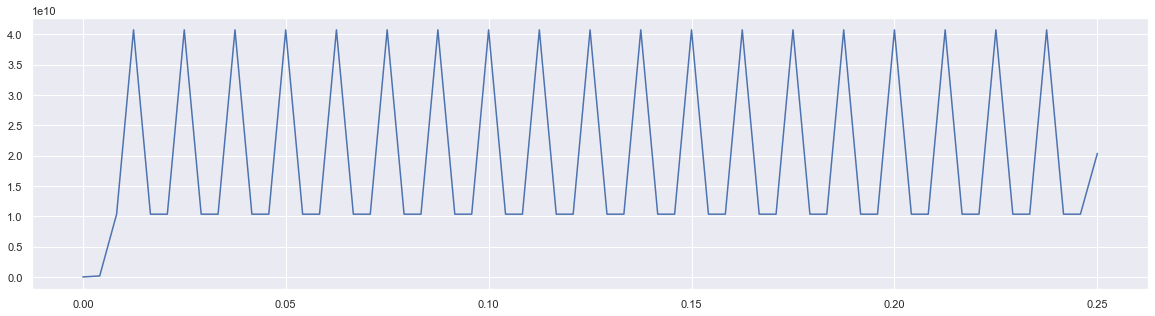

In [379]:
f, Pxx = sp.signal.welch(zeroed[:120], fs = .5)
plt.plot(f, Pxx)

In [311]:
%%time
mbps = 5
peaks_240 = [peak_time_diff(df, '2->1Bytes', mbps) for df in chunk_240_lst]
peaks_360 = [peak_time_diff(df, '2->1Bytes', mbps) for df in chunk_360_lst]
peaks_480 = [peak_time_diff(df, '2->1Bytes', mbps) for df in chunk_480_lst]
peaks_720 = [peak_time_diff(df, '2->1Bytes', mbps) for df in chunk_720_lst]
peaks_1080 = [peak_time_diff(df, '2->1Bytes', mbps) for df in chunk_1080_lst]

Wall time: 3.14 s


In [312]:
np.mean(peaks_240, axis=0)

array([ 1.92634416,  7.70547945, 17.93057994])

In [313]:
np.mean(peaks_360, axis=0)

array([ 3.90822763,  7.54421769, 19.37638397])

In [314]:
np.mean(peaks_480, axis=0)

array([ 4.51699202,  9.41496599, 15.3824159 ])

In [315]:
np.mean(np.nan_to_num(peaks_720), axis=0)

array([ 3.76547409, 13.42068966, 11.75154071])

In [316]:
np.mean(peaks_1080, axis=0)

array([ 4.00724229, 20.64383562,  7.33266208])

## Spectral Features

In [103]:
def explode_extended(df):
    """
    takes in a network-stats df and explodes the extended columns.
    time is converted from seconds to milliseconds.
    drop the ip address columns and the aggregate columns.
    """
    ext_col = ['packet_times', 'packet_sizes', 'packet_dirs']
    
    pre_explode = df[ext_col].apply(lambda x: x.str.split(';').str[:-1])
    
    exploded = pre_explode[ext_col].apply(lambda x: x.explode(ignore_index=True).astype(np.int64))
    exploded.columns = ['Time', 'pkt_size', 'pkt_dir']

    _sorted = exploded.sort_values('Time')
    _sorted['Time'] = pd.to_datetime(_sorted['Time'], unit='ms')

    return _sorted
  
def spectral_features(df, col):
    """
    welch implemention of spectral features
    resample the data before inputting (might change prereq depending on
    resource allocation)
    """

    f, Pxx_den = sp.signal.welch(df[col], fs=2)
    Pxx_den = np.sqrt(Pxx_den)

    peaks = sp.signal.find_peaks(Pxx_den)[0]
    prominences = sp.signal.peak_prominences(Pxx_den, peaks)[0]

    idx_max = prominences.argmax()
    loc_max = peaks[idx_max]

    return [f[loc_max], Pxx_den[loc_max], prominences[idx_max]]
  
def power_density(df, bins):
  
  f_temp, Pxx_temp = sp.signal.welch(df['pkt_size'], fs=.5) 
  Pxx_temp = np.sqrt(Pxx_temp)
  freq = np.linspace(0, np.max(f_temp) + .01, num=bins) - .001
  total = np.trapz(y=Pxx_temp, x=f_temp)
  temp_lst = []
  
  for i in np.arange(len(freq) - 1):

    f_lower = np.where(f_temp >= freq[i])
    f_upper = np.where(f_temp < freq[i+1] )
    selected_range = np.intersect1d(f_lower, f_upper)

    pxx_den = np.trapz(y=Pxx_temp[selected_range], x=f_temp[selected_range]) / total
    temp_lst.append(pxx_den)

  return temp_lst

def temp_name(df):
  f_temp, Pxx_temp = sp.signal.welch(df['pkt_size'], fs=2) 
  return np.sum((Pxx_temp/np.sum(Pxx_temp)) * f_temp)

In [104]:
%%time
size='500ms'
resample_240 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_240_lst]
resample_360 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_360_lst]
resample_480 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_480_lst]
resample_720 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_720_lst]
resample_1080 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

Wall time: 38 s


In [105]:
%%time
size='2000ms'

resample_240 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_240_lst]
resample_360 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_360_lst]
resample_480 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_480_lst]
resample_720 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_720_lst]
resample_1080 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

Wall time: 39 s


In [260]:
## area under the curve for a periodogram

In [164]:
bins = 3
pxx_den_240 = [power_density(df, bins) for df in resample_240]
pxx_den_360 = [power_density(df, bins) for df in resample_360]
pxx_den_480 = [power_density(df, bins) for df in resample_480]
pxx_den_720 = [power_density(df, bins) for df in resample_720]
pxx_den_1080 = [power_density(df, bins) for df in resample_1080]

pxx_den_df = pd.DataFrame({
  "240p": np.mean(pxx_den_240, axis=0),
  "360p": np.mean(pxx_den_360, axis=0),
  "480p": np.mean(pxx_den_480, axis=0),
  "720p": np.mean(pxx_den_720, axis=0),
  "1080p": np.mean(pxx_den_1080, axis=0)
}).T

#pxx_den_df.columns = ['[-.001, .086)', '[.086, .172)', '[.172, .259)']
pxx_den_df['St_dev'] = [
  np.mean(np.std(pxx_den_240, axis=1)),
  np.mean(np.std(pxx_den_360, axis=1)),
  np.mean(np.std(pxx_den_480, axis=1)),
  np.mean(np.std(pxx_den_720, axis=1)), 
  np.mean(np.std(pxx_den_1080, axis=1))]

pxx_den_df

,0,1,St_dev
240p,0.480977,0.481742,0.041264
360p,0.488182,0.476091,0.035443
480p,0.483043,0.481190,0.041447
720p,0.450948,0.516071,0.057571
1080p,0.406425,0.558447,0.114911


In [110]:
bins = 4
pxx_den_240 = [power_density(df, bins) for df in resample_240]
pxx_den_360 = [power_density(df, bins) for df in resample_360]
pxx_den_480 = [power_density(df, bins) for df in resample_480]
pxx_den_720 = [power_density(df, bins) for df in resample_720]
pxx_den_1080 = [power_density(df, bins) for df in resample_1080]

pxx_den_df = pd.DataFrame({
  "240p": np.mean(pxx_den_240, axis=0),
  "360p": np.mean(pxx_den_360, axis=0),
  "480p": np.mean(pxx_den_480, axis=0),
  "720p": np.mean(pxx_den_720, axis=0),
  "1080p": np.mean(pxx_den_1080, axis=0)
}).T

#pxx_den_df.columns = ['[-.001, .086)', '[.086, .172)', '[.172, .259)']
pxx_den_df['St_dev'] = [
  np.mean(np.std(pxx_den_240, axis=1)),
  np.mean(np.std(pxx_den_360, axis=1)),
  np.mean(np.std(pxx_den_480, axis=1)),
  np.mean(np.std(pxx_den_720, axis=1)), 
  np.mean(np.std(pxx_den_1080, axis=1))]

pxx_den_df

,0,1,2,St_dev
240p,0.299449,0.334615,0.296464,0.046590
360p,0.312517,0.320708,0.294801,0.038955
480p,0.300467,0.334170,0.292896,0.041988
720p,0.218569,0.364955,0.349525,0.088527
1080p,0.214826,0.338025,0.383048,0.111647


## Rolling Windows

In [261]:
def rolling(df, sample_size):
  
  return df.rolling(sample_size).mean()

In [253]:
def rolling_normalized_std(df, sample_size):
    
    df_roll = df.rolling(sample_size).mean()
    
    roll_mean = df_roll['pkt_size'].mean()
    roll_std = df_roll['pkt_size'].std()

    normalized_std = roll_std / roll_mean

    return [normalized_std, roll_mean * mbit_rate, roll_std * mbit_rate]

In [287]:
window = 4
normalized_std_240 = [rolling_normalized_std(df, window) for df in resample_240]
normalized_std_360 = [rolling_normalized_std(df, window) for df in resample_360]
normalized_std_480 = [rolling_normalized_std(df, window) for df in resample_480]
normalized_std_720 = [rolling_normalized_std(df, window) for df in resample_720]
normalized_std_1080 = [rolling_normalized_std(df, window) for df in resample_1080]

CoV on a rolling window average

In [255]:
np.mean(normalized_std_240, axis=0)

array([0.72894597, 0.72543243, 0.52756132])

In [256]:
np.mean(normalized_std_360, axis=0)

array([0.84751147, 0.97192882, 0.79310161])

In [257]:
np.mean(normalized_std_480, axis=0)

array([0.62664745, 1.45663224, 0.81783882])

In [258]:
np.mean(normalized_std_720, axis=0)

array([0.40209471, 2.81181233, 0.87218488])

In [259]:
np.mean(normalized_std_1080, axis=0)

array([0.33518229, 4.7814191 , 1.39700843])

In [220]:
def normalized_std(df, col_lst):
  df_avg = np.mean(df)
  df_std = np.std(df)
  
  return df_std[col_lst].values / df_avg[col_lst].values

In [372]:
%%time
feat_lst = ['1->2Bytes', '2->1Bytes']

normalized_std_240 = [normalized_std(df, feat_lst) for df in chunk_240_lst]
normalized_std_360 = [normalized_std(df, feat_lst) for df in chunk_360_lst]
normalized_std_480 = [normalized_std(df, feat_lst) for df in chunk_480_lst]
normalized_std_720 = [normalized_std(df, feat_lst) for df in chunk_720_lst]
normalized_std_1080 = [normalized_std(df, feat_lst) for df in chunk_1080_lst]

Wall time: 11.9 s


cofficient of variation - download & upload

In [373]:
np.mean(normalized_std_240, axis=0)

array([3.37829584, 4.53483563])

In [374]:
np.mean(normalized_std_360, axis=0)

array([3.87138975, 4.94411379])

In [375]:
np.mean(normalized_std_480, axis=0)

array([3.17790788, 3.8543255 ])

In [376]:
np.mean(normalized_std_720, axis=0)

array([2.55817227, 2.86250285])

In [377]:
np.mean(normalized_std_1080, axis=0)

array([2.2350202 , 2.37060233])

difference in cofficient of variation between upload and download bytes

In [250]:
np.mean(np.array(normalized_std_240)[:, 0] - np.array(normalized_std_240)[:, 1])

-1.156539796518921

In [248]:
np.mean(np.array(normalized_std_360)[:, 0] - np.array(normalized_std_360)[:, 1])

-1.0727240344724294

In [247]:
np.mean(np.array(normalized_std_480)[:, 0] - np.array(normalized_std_480)[:, 1])

-0.6764176194435648

In [251]:
np.mean(np.array(normalized_std_720)[:, 0] - np.array(normalized_std_720)[:, 1])

-0.30433057755664644

In [252]:
np.mean(np.array(normalized_std_1080)[:, 0] - np.array(normalized_std_1080)[:, 1])

-0.13558213018297424

In [90]:
%%time
size='500ms'
resample_240 = [explode_extended(df) for df in chunk_240_lst]
resample_360 = [explode_extended(df) for df in chunk_360_lst]
resample_480 = [explode_extended(df) for df in chunk_480_lst]
resample_720 = [explode_extended(df) for df in chunk_720_lst]
resample_1080 = [explode_extended(df) for df in chunk_1080_lst]

Wall time: 28.8 s


## Chunking & Feature creation

In [ ]:
def create_features(path, interval)

In [378]:
## wip; need to decide chunk size eventually
## should we also make this chunking feature be our feature creation?

def chunk_data(df, interval=120):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [ ]:
def create_features(df, interval=60):

  features = [
    'dwl_peak_freq',
    'dwl_peak_prom',
    'dwl_max_psd',
    'dwl_bytes_avg',
    'dwl_bytes_std',
    'dwl_peak_avg',
    'dwl_peak_var',
    'dwl_peak_std',
    'upl_peak_freq',
    'upl_peak_prom',
    'upl_max_psd',
    'upl_bytes_avg',
    'upl_bytes_std',
    'upl_peak_avg',
    'upl_peak_var',
    'upl_peak_std',
    'IMAN_dwn_time_peak',#'IMAN_up_time_peak',
    'IMAN_dwn_num_peak'#,'IMAN_up_num_peak'
  ]  

  vals = []

  df_chunks = chunk_data(df, interval)

  for chunk in df_chunks:

    preproc = convert_ms_df(chunk, True)
    upl_bytes = preproc[preproc['pkt_src'] == '1'].resample('500ms', on='Time').sum()
    dwl_bytes = preproc[preproc['pkt_src'] == '2'].resample('500ms', on='Time').sum()

    ## spectral features
    dwl_spectral = spectral_features(dwl_bytes, 'pkt_size')
    upl_spectral = spectral_features(upl_bytes, 'pkt_size')
    
    ## aggregate features
    dwl_agg = agg_feat(chunk, '2->1Bytes')
    upl_agg = agg_feat(chunk, '1->2Bytes')
    
    ## peak features
    dwl_peak = peak_time_diff(chunk, '2->1Bytes')
    upl_peak = peak_time_diff(chunk, '1->2Bytes')
    
    ## iman's time between peak 
    iman_dwn_time_peak = np.mean(peak_times(chunk,'2->1Bytes',1000000))
    #iman_up_time_peak = np.mean(peak_times(chunk,'1->2Bytes',50000))

    ## iman's num peak
    iman_dwn_num_peak = num_peaks(chunk,'2->1Bytes',1000000)
    #iman_up_num_peak = num_peaks(chunk,'1->2Bytes',50000)

    feat_val = np.hstack((
      dwl_spectral,
      dwl_agg,
      dwl_peak,
      upl_spectral,
      upl_agg,
      upl_peak,
      iman_dwn_time_peak,
      #iman_up_time_peak,
      iman_dwn_num_peak,
      #iman_up_num_peak
    ))
    
    vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

In [ ]:
def create_features_no_split(df, interval=60):

  features = [
    'peak_freq',
    'peak_prom',
    'max_psd',
    'bytes_avg',
    'bytes_std',
    'peak_avg',
    'peak_var',
    'peak_std',
  ]  

  vals = []

  df_chunks = chunk_data(df, interval)

  for chunk in df_chunks:

    preproc = convert_ms_df(chunk, True)

    ## spectral features
    spectral_feat = spectral_features(preproc, 'pkt_size')
    
    ## aggregate features
    aggr_feat = agg_feat(chunk, '2->1Bytes')
    
    ## peak features
    peak_feat = peak_time_diff(chunk, '2->1Bytes')
    
    feat_val = np.hstack((
      spectral_feat,
      aggr_feat,
      peak_feat
    ))
    
    vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

In [ ]:
low_feat_no_split = create_features_no_split(stdoan_low, 100)

## Dev Playground

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [ ]:
%%time
low_feat = pd.concat([create_features(df, 100) for df in low_dfs])
med_feat = pd.concat([create_features(df, 100) for df in med_dfs])
high_feat = pd.concat([create_features(df, 100) for df in high_dfs])

In [ ]:
low_feat['resolution'] = np.zeros(len(low_feat))
med_feat['resolution'] = np.zeros(len(med_feat)) + 1
high_feat['resolution'] = np.zeros(len(high_feat)) + 2

In [ ]:
training_split = pd.concat([low_feat, med_feat, high_feat])

In [ ]:
X, y = training_split.drop(columns=['resolution']), training_split['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

In [ ]:
clf_split = RandomForestClassifier(n_estimators = 5, max_depth = 2, criterion = 'entropy', random_state = 42)
clf_split.fit(X_train, y_train)

In [ ]:
y_pred = clf_split.predict(X_test)

In [ ]:
np.abs(training_split.corr()['resolution']).sort_values(ascending=False)

In [ ]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
f1_score(y_test, y_pred, average=None)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
features = [
  'dwl_peak_freq',
  'dwl_peak_prom',
  'dwl_max_psd',
  'dwl_bytes_avg',
  'dwl_bytes_std',
  'dwl_peak_avg',
  'dwl_peak_var',
  'dwl_peak_std',
  'upl_peak_freq',
  'upl_peak_prom',
  'upl_max_psd',
  'upl_bytes_avg',
  'upl_bytes_std',
  'upl_peak_avg',
  'upl_peak_var',
  'upl_peak_std',
  'IMAN_dwn_time_peak',#'IMAN_up_time_peak'
            'IMAN_dwn_num_peak']#,'IMAN_up_num_peak']
importances = clf_split.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])
    

In [ ]:
import dill

In [ ]:
dill.dump(clf_split, open("randomforest_chkpt2.obj", "wb"))

In [ ]:
dill.load(open("randomforest_chkpt2.obj", "rb"))

In [ ]:
pip install scikit-learn

## no split (download focus)

In [ ]:
%%time
low_feat_no_split = create_features_no_split(stdoan_low, 100)
med_feat_no_split = create_features_no_split(stdoan_med, 100)
high_feat_no_split = create_features_no_split(stdoan_high, 100)

In [ ]:
low_feat_no_split['resolution'] = np.zeros(len(low_feat))
med_feat_no_split['resolution'] = np.zeros(len(med_feat)) + 1
high_feat_no_split['resolution'] = np.zeros(len(high_feat)) + 2

In [ ]:
training_no_split = pd.concat([low_feat_no_split, med_feat_no_split, high_feat_no_split])

In [ ]:
X, y = training_no_split.drop(columns=['resolution']), training_no_split['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

In [ ]:
clf_no_split = RandomForestClassifier(n_estimators = 2, max_depth = 2, criterion = 'entropy', random_state = 42)
clf_no_split.fit(X_train, y_train)

In [ ]:
y_pred = clf_no_split.predict(X_test)

In [ ]:
np.abs(training_no_split.corr()['resolution']).sort_values(ascending=False)

In [ ]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
f1_score(y_test, y_pred, average=None)